In [1]:
from __future__ import print_function, division
import cv2
import os
from skimage import io, transform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [2]:
landmarks_frame = pd.read_csv('./face_landmarks.csv')

In [4]:
n = 75
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2) # (68, 2)

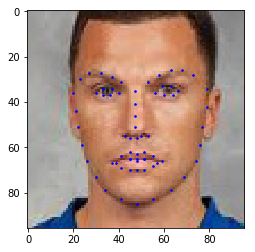

In [5]:
# landmarks 찍는 방법

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('', img_name)), landmarks)
plt.show()

In [19]:
np.transpose(x, (0, 3, 1, 2)).shape

(1, 3, 96, 96)

In [25]:
#F to 12 x 12 x 256
#stacked transposed convolutions, separated by ReLUs, with a kernel width of 5 and stride of 2 to upsample to 96 x 96 x 32
#1 x 1 convolution to 96 x 96 x 3

# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(17)

f_vector = 128 # nn4 model의 output layer 전 마지막 layer dimension
landmark_num = 68

class Decoder(nn.Module):
    
    def __init__(self, useCude=False):
        super(Decoder, self).__init__()
        
        self.base_fc = nn.Linear(f_vector, f_vector)
        
        self.shallow_mlp = nn.Sequential(
            nn.Linear(f_vector, 100), # hidden1
            nn.ReLU(),
            nn.Linear(100, 68), # out
            nn.ReLU())
                
        self.texture_fc = nn.Linear(f_vector, 256 * 12 * 12)
        
        self.tConv1 = nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2)
        self.tConv2 = nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2)
        self.tConv3 = nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2)
        
        self.conv = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU())

    # x := 논문에서 1024, 우리는 736 vector
    def forward(self, x):
        feature_vec = self.base_fc(x)
        
        x1 = self.shallow_mlp(feature_vec)
        y1 = self.shallow_mlp(feature_vec)
        
        texture_out = self.texture_fc(feature_vec)
        texture_out = texture_out.view(1, 256, 12, 12)
        texture_out = F.relu(self.tConv1(texture_out, output_size=[None, None, 24, 24]))
        texture_out = F.relu(self.tConv2(texture_out, output_size=[None, None, 48, 48]))
        texture_out = F.relu(self.tConv3(texture_out, output_size=[None, None, 96, 96]))
        texture_out = self.conv(texture_out)
        return x1, y1, texture_out

dtype = torch.FloatTensor

# input : 736 dimension
x = Variable(torch.randn(1, 1, 1, f_vector))

## ground_truth_textures := actual input image
##y = Variable(ground_truth_textures, requires_grad=False)
# ground_truth_textures = Variable(torch.randn(1, 3, 96, 96), requires_grad=False)
#landmark_x = Variable(torch.randn(1, landmark_num))
#landmark_y = Variable(torch.randn(1, landmark_num))

model = Decoder()

loss_fn_landmark = torch.nn.MSELoss(size_average=False)
loss_fn_texture = torch.nn.L1Loss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(5):
    for idx in range(len(landmarks_frame)):
        img_name = landmarks_frame.ix[idx, 0]
        landmarks = landmarks_frame.ix[idx, 1:].as_matrix().astype('float').reshape(-1, 2)
        
        landmark_x = Variable(torch.from_numpy(landmarks[:, 0]))
        landmark_y = Variable(torch.from_numpy(landmarks[:, 1]))
        textures = io.imread(os.path.join('', img_name))[None, :, :, :]
        ground_truth_textures = Variable(torch.from_numpy(np.transpose(textures, (0, 3, 1, 2))), requires_grad=False)
        
        model.zero_grad()
        x_pred, y_pred, texture_pred = model(x)

        loss_x = loss_fn_landmark(x_pred, landmark_x)
        loss_y = loss_fn_landmark(y_pred, landmark_y)
        loss_texture = loss_fn_texture(texture_pred, ground_truth_textures)

        total_loss = loss_x + loss_y + loss_texture
        if (epoch % 100 == 0):
            print(epoch, total_loss.data[0])

        optimizer.zero_grad()

        total_loss.backward()

        optimizer.step()

TypeError: FloatMSECriterion_updateOutput received an invalid combination of arguments - got ([32;1mint[0m, [32;1mtorch.FloatTensor[0m, [31;1mtorch.DoubleTensor[0m, [32;1mtorch.FloatTensor[0m, [32;1mbool[0m), but expected (int state, torch.FloatTensor input, torch.FloatTensor target, torch.FloatTensor output, bool sizeAverage)